In [83]:
import os
from datetime import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
import yfinance as yf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

IMPORTS

In [211]:
df = pd.DataFrame(yf.download(tickers='GOOG',start="2000-01-01",end="2024-05-01"))
# Slice [start:stop:step], starting from index 5 take every 6th record.




[*********************100%%**********************]  1 of 1 completed


In [212]:
def calc_macd(data, len1,len2,len3):
    shortEMA = data.ewm(span = len1, adjust= False).mean()
    longEMA = data.ewm(span = len2, adjust= False).mean()
    MACD = shortEMA-longEMA
    signal = MACD.ewm(span = len3 , adjust= False).mean()
    return MACD , signal

def calc_rsi(data,period):
    delta = data.diff() #egy nappal shiftelt diff
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com = period, adjust=False).mean()
    ema_down = down.ewm(com = period, adjust=False).mean()
    rs = ema_up / ema_down
    rsi = 100 - (100/(1+rs))
    return rsi

In [214]:
df['Prev_close'] = df.loc[:,'Close'].shift(1)
df['Prev_volume'] = df.loc[:,'Volume'].shift(1)
df['Prev_Open']= df.loc[:,'Open'].shift(1)
df['Prev_Hi']=df.loc[:,'High'].shift(1)
df['Prev_lo']=df.loc[:,'Low'].shift(1)



datetimes = df.index.values
weekdays = []

for dt in datetimes:
    dt = datetime.strptime(str(dt), '%Y-%m-%dT%H:%M:%S.000000000')
    weekdays.append(dt.weekday())
df['Weekday'] = weekdays    

df["5SMA"] = df['Prev_close'].rolling(5).mean()
df["10SMA"] = df['Prev_close'].rolling(10).mean()
df["50SMA"] = df['Prev_close'].rolling(50).mean()
df["200SMA"] = df['Prev_close'].rolling(200).mean()
df["Move_direct"]= (1-df['Prev_Open'] / df["Prev_close"] )*100
df["OBV"]=np.where(df['Prev_close'] > df['Prev_close'].shift(1), df['Prev_volume'], np.where(df['Prev_close'] < df['Prev_close'].shift(1), -df['Prev_volume'], 0)).cumsum()
df["TR"]=np.maximum(df["Prev_Hi"]-df["Prev_lo"],df["Prev_Hi"]-df["Prev_close"].shift(1),df["Prev_close"].shift(1)-df["Prev_lo"])
df['ATR14'] = df["TR"].rolling(14).mean()
df["+DM"]=df["Prev_Hi"].shift(1)-df["Prev_Hi"]
df["-DM"]=df["Prev_lo"].shift(1)-df["Prev_lo"]
df["EMA14+"]=df["+DM"].ewm(com=0.1).mean()
df["EMA14-"]=df["-DM"].ewm(com=0.1).mean()
#df["Prediction"]= df['Close'].transform(lambda x : np.sign(x.diff()))

df["+DI14"]=(df["EMA14+"]/df['ATR14'])*100
df["-DI14"]=(df["EMA14-"]/df['ATR14'])*100
df["DI14"]= np.abs(df["+DI14"]-df["-DI14"]) / np.abs(df["+DI14"] + df["-DI14"])
df["ADX14"]= (df["DI14"].shift(1)*13 + df["DI14"])*100
df["ADXUT"]= np.where((df["ADX14"] < 25) & (df["ADX14"].shift(1) > 25) & (df["+DI14"] > df["-DI14"]),1,0)
df["ADXDT"]= np.where((df["ADX14"] < 25) & (df["ADX14"].shift(1) > 25) & (df["+DI14"] < df["-DI14"]),-1,0)
df["StcOsc"]= 100*(df["Prev_close"]-df["Prev_close"].rolling(14).min())/(df["Prev_close"].rolling(14).max() - df["Prev_close"].rolling(14).min())
macd,signal = calc_macd(df['Prev_close'],12,26,9)
df['MACD'] = macd
df['MACD_signal']=signal
df['RSI'] = calc_rsi(df['Prev_close'],13)
df['RSI_volume'] = calc_rsi(df['Prev_volume'],13)


df.dropna()

,Open,High,Low,Close,Adj Close,Volume,Prev_close,Prev_volume,Prev_Open,Prev_Hi,...,-DI14,DI14,ADX14,ADXUT,ADXDT,StcOsc,MACD,MACD_signal,RSI,RSI_volume
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-06,7.033387,7.316327,7.019439,7.246339,7.246339,904413304,6.980336,7.541080e+08,7.142976,7.205492,...,75.926524,0.830538,3448.320533,0,0,86.409177,0.449593,0.373670,79.570228,52.360364
2005-06-07,7.399764,7.461781,7.230399,7.300635,7.300635,976566743,7.246339,9.044133e+08,7.033387,7.316327,...,-38.623071,0.072590,1086.957990,0,0,100.000000,0.467185,0.392373,82.771410,54.601082
2005-06-08,7.293911,7.302379,6.924047,6.962901,6.962901,1031889331,7.300635,9.765667e+08,7.399764,7.461781,...,-85.520663,0.171112,111.478443,0,0,100.000000,0.479975,0.409893,83.345073,55.678782
2005-06-09,7.091420,7.185567,6.987808,7.131021,7.131021,660109011,6.962901,1.031889e+09,7.293911,7.302379,...,104.877532,0.326913,255.136470,0,0,74.860973,0.457585,0.419432,68.145399,56.530830
2005-06-10,7.147958,7.155181,6.974358,7.036127,7.036127,509767599,7.131021,6.601090e+08,7.091420,7.185567,...,-13.242016,1.817514,606.738342,0,0,86.779294,0.448239,0.425193,70.982315,49.626319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,159.089996,161.389999,158.820007,161.100006,161.100006,19485700,159.919998,1.611540e+07,158.589996,160.479996,...,-69.164843,0.271994,217.041851,0,0,90.169537,2.891209,3.153873,63.282152,46.919148
2024-04-25,153.360001,158.279999,152.768005,157.949997,157.949997,36197800,161.100006,1.948570e+07,159.089996,161.389999,...,-31.691025,0.018951,355.486846,0,0,100.000000,3.006017,3.124302,65.097458,50.040413
2024-04-26,175.990005,176.419998,171.399994,173.690002,173.690002,56500800,157.949997,3.619780e+07,153.360001,158.279999,...,168.330629,0.327584,57.395258,0,0,41.449697,2.810427,3.061527,56.996566,61.979219


In [215]:
df.head(20)


,Open,High,Low,Close,Adj Close,Volume,Prev_close,Prev_volume,Prev_Open,Prev_Hi,...,-DI14,DI14,ADX14,ADXUT,ADXDT,StcOsc,MACD,MACD_signal,RSI,RSI_volume
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488,2.499133,897427216.0,2.490664,2.591785,...,NaN,NaN,NaN,0,0,NaN,0.000000,0.000000,NaN,NaN
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939,2.697639,458857488.0,2.515820,2.716817,...,NaN,NaN,NaN,0,0,NaN,0.015835,0.003167,100.000000,0.000000
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159,2.724787,366857939.0,2.758411,2.826406,...,NaN,NaN,NaN,0,0,NaN,0.030227,0.008579,100.000000,0.000000
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512,2.611960,306396159.0,2.770615,2.779581,...,NaN,NaN,NaN,0,0,NaN,0.032158,0.013295,95.547973,0.000000
2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401,2.640104,184645512.0,2.614201,2.689918,...,NaN,NaN,NaN,0,0,NaN,0.035549,0.017746,95.600589,0.000000
2004-08-27,2.692408,2.705360,2.632383,2.643840,2.643840,124826132,2.687676,142572401.0,2.613952,2.688672,...,NaN,NaN,NaN,0,0,NaN,0.041596,0.022516,95.693240,0.000000
2004-08-30,2.622171,2.627402,2.540727,2.540727,2.540727,104429967,2.643840,124826132.0,2.692408,2.705360,...,NaN,NaN,NaN,0,0,NaN,0.042362,0.026485,93.734306,0.000000
2004-08-31,2.547950,2.583068,2.544463,2.549693,2.549693,98825037,2.540727,104429967.0,2.622171,2.627402,...,NaN,NaN,NaN,0,0,NaN,0.034254,0.028039,89.113163,0.000000


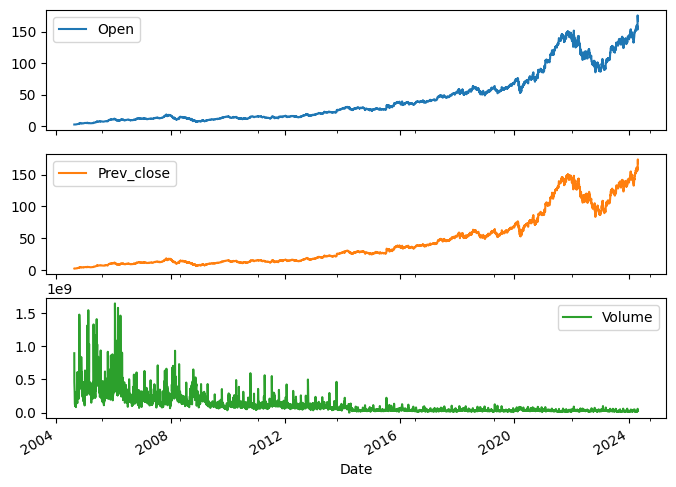

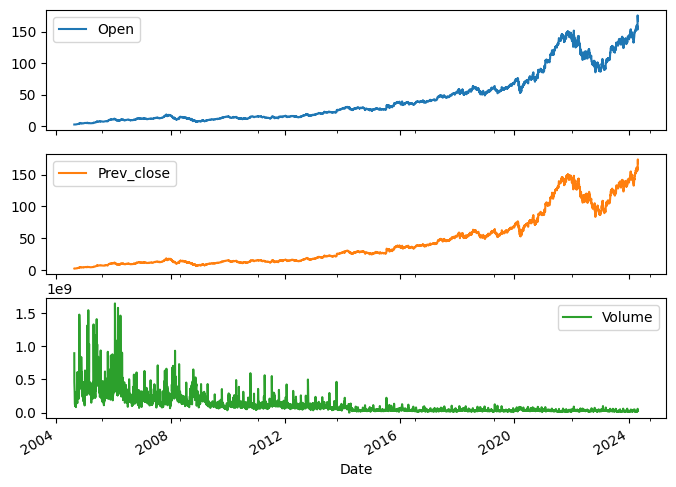

In [217]:
plot_cols = ['Open', 'Prev_close', 'Volume']
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True)

In [218]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,4958.0,4.358902e+01,4.095620e+01,2.470490,1.294205e+01,2.684604e+01,5.923875e+01,1.759900e+02
High,4958.0,4.405113e+01,4.141951e+01,2.534002,1.309504e+01,2.702455e+01,5.977076e+01,1.764200e+02
Low,4958.0,4.315095e+01,4.054722e+01,2.390042,1.281752e+01,2.661963e+01,5.863800e+01,1.714000e+02
Close,4958.0,4.361005e+01,4.099075e+01,2.490913,1.295295e+01,2.683450e+01,5.927563e+01,1.736900e+02
Adj Close,4958.0,4.361005e+01,4.099075e+01,2.490913,1.295295e+01,2.683450e+01,5.927563e+01,1.736900e+02
Volume,4958.0,1.169832e+08,1.503189e+08,158434.000000,2.789550e+07,5.807397e+07,1.449643e+08,1.650833e+09
Prev_close,4957.0,4.358564e+01,4.095881e+01,2.490913,1.295245e+01,2.683450e+01,5.927000e+01,1.736900e+02
Prev_volume,4957.0,1.170008e+08,1.503290e+08,158434.000000,2.789400e+07,5.814914e+07,1.449653e+08,1.650833e+09
Prev_Open,4957.0,4.356405e+01,4.092257e+01,2.470490,1.294099e+01,2.684530e+01,5.920500e+01,1.759900e+02
Prev_Hi,4957.0,4.402575e+01,4.138511e+01,2.534002,1.309492e+01,2.702331e+01,5.977050e+01,1.764200e+02


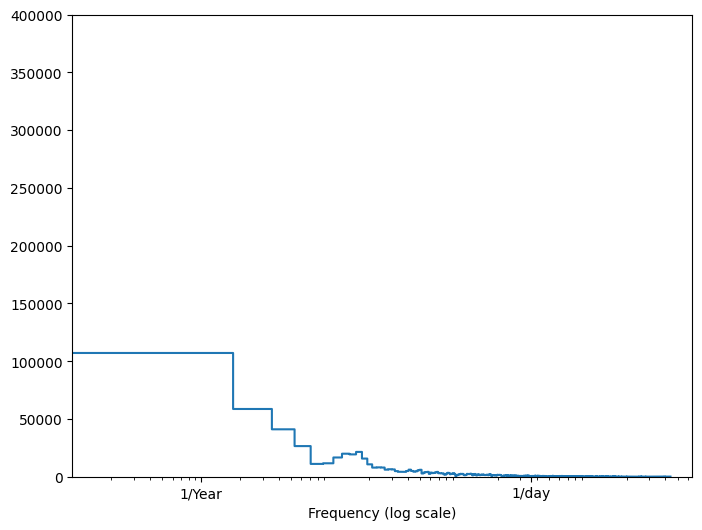

In [220]:
fft = tf.signal.rfft(df['Open'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Open'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [221]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


/var/folders/f2/r3lyrxjd5kv053b6mnc531pw0000gn/T/ipykernel_7268/1230219294.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


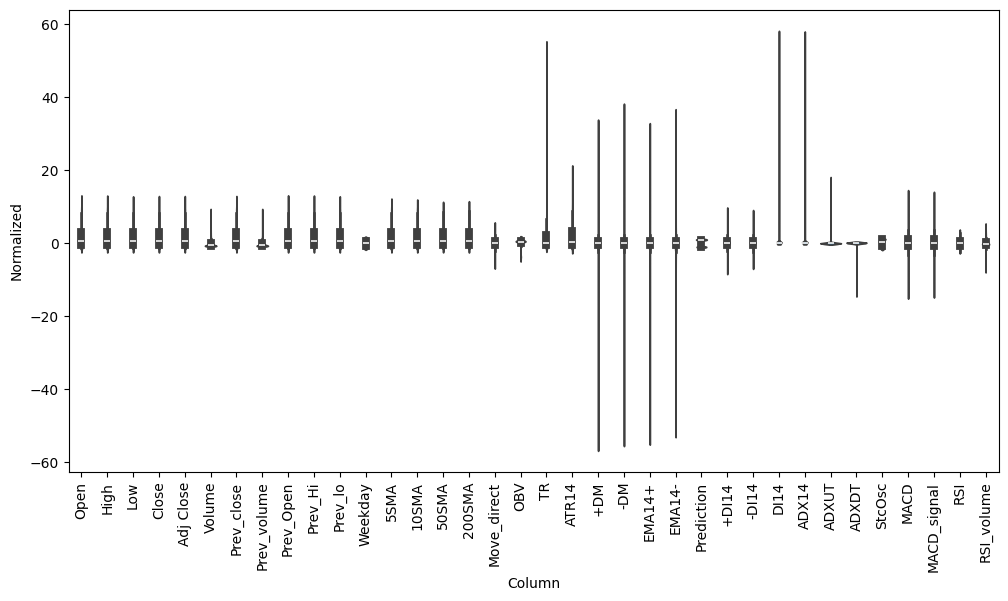

In [222]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [224]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [225]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Open'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Open']

In [226]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Open'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Open']

In [227]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [228]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 36)
Inputs shape: (3, 6, 36)
Labels shape: (3, 1, 1)


In [229]:
w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='Open', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Index')

WindowGenerator.plot = plot

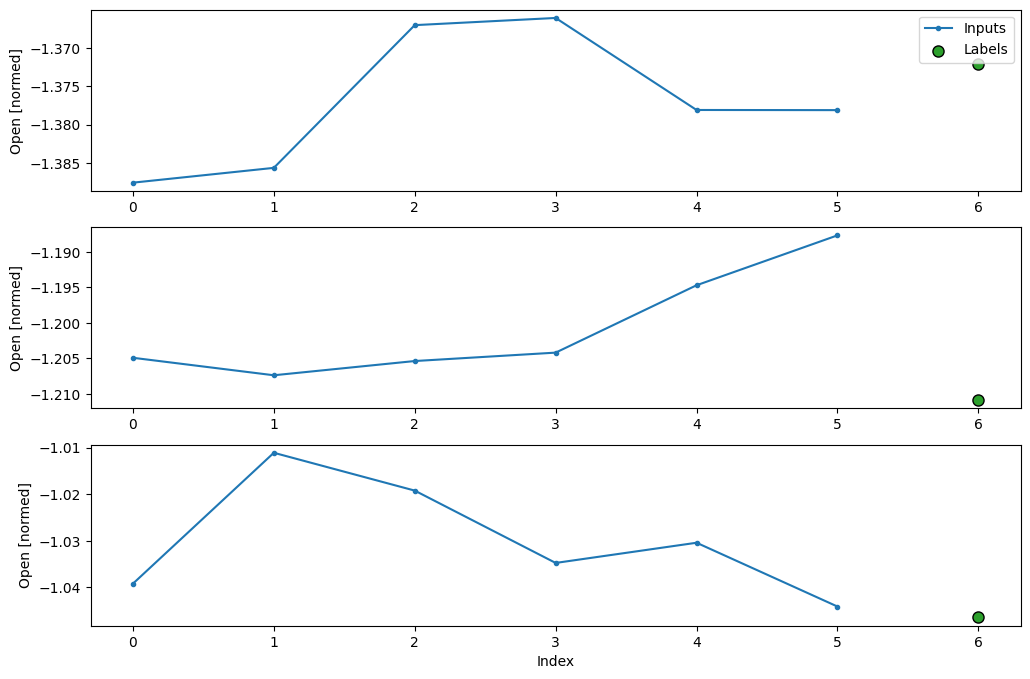

In [230]:
w2.plot()

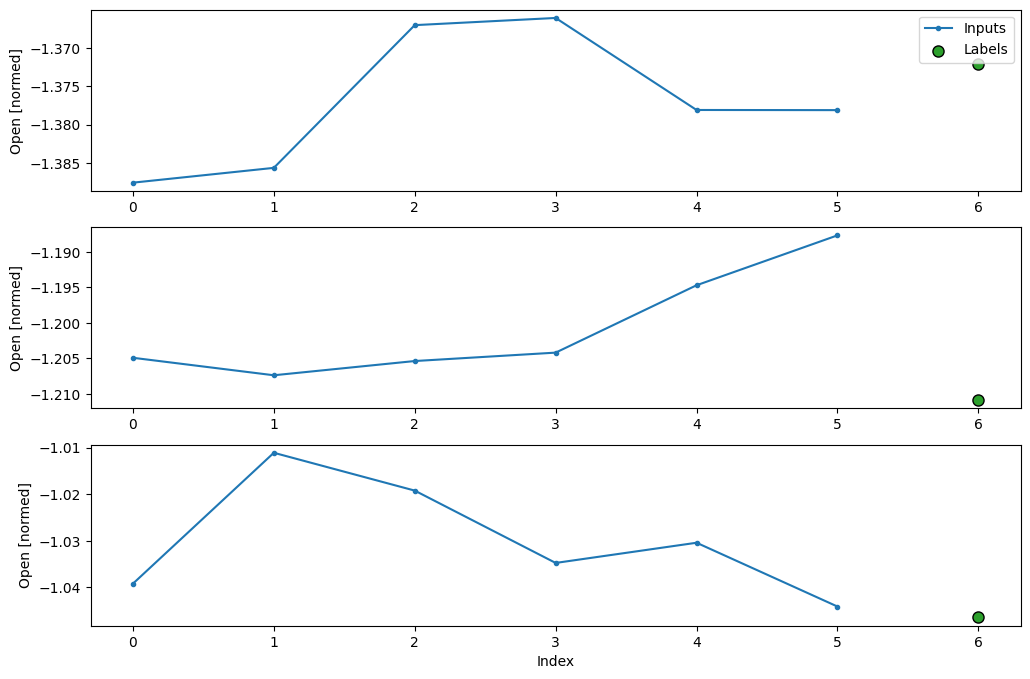

In [231]:
w2.plot(plot_col='Open')

In [232]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [233]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [234]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 36), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [235]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 36)
Labels shape (batch, time, features): (32, 1, 1)


2024-05-22 11:40:56.211750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [237]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Open'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Open']

In [238]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 36)
Labels shape (batch, time, features): (32, 1, 1)


2024-05-22 11:41:06.330336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [239]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [240]:
baseline = Baseline(label_index=column_indices['Open'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 0.0178 - mean_absolute_error: 0.0909


In [241]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Open'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Open']

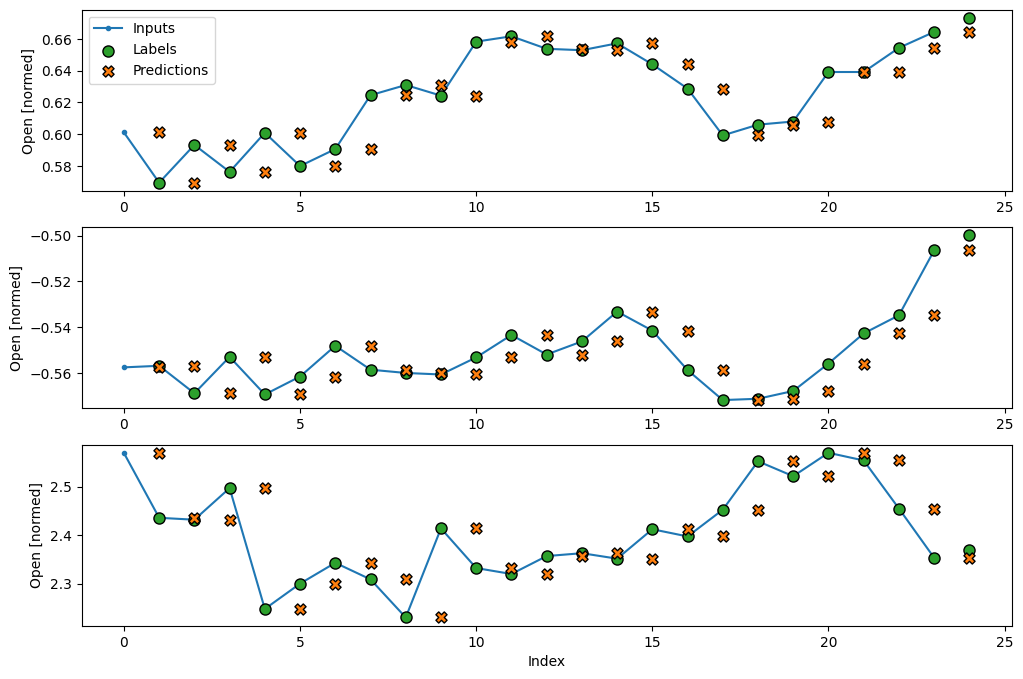

In [242]:
wide_window.plot(baseline)

In [243]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [244]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 36)
Output shape: (32, 1, 1)


In [245]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [246]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: nan - mean_absolute_error: nan


In [247]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 36)
Output shape: (32, 24, 1)


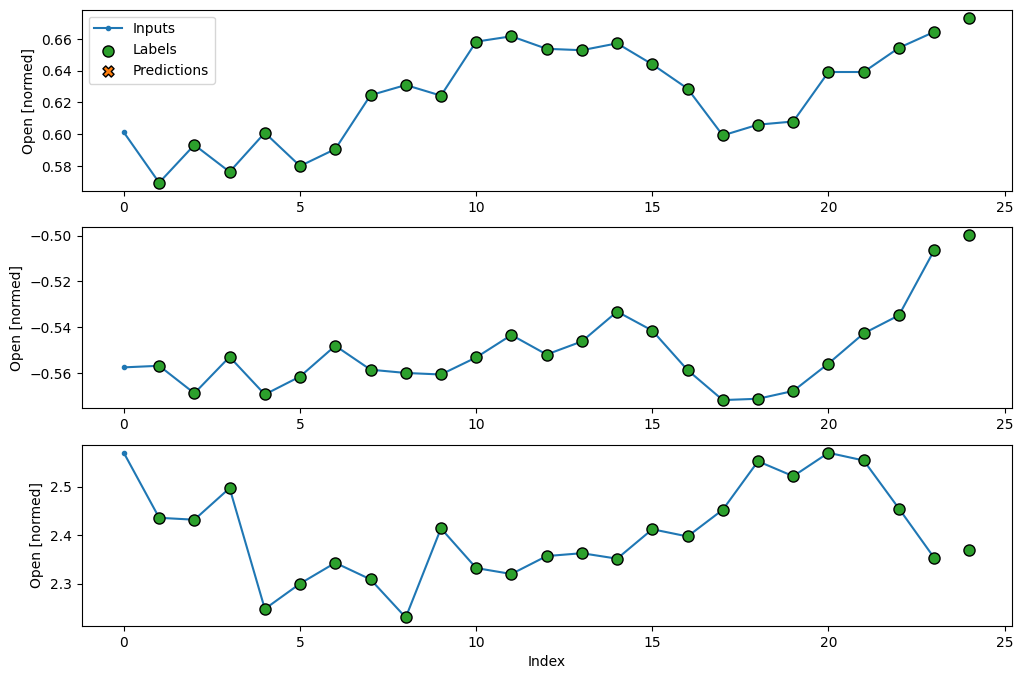

In [248]:
wide_window.plot(linear)

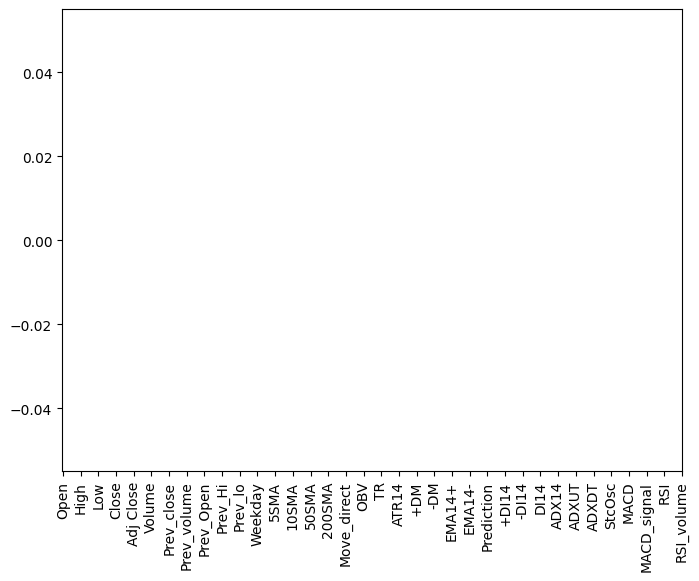

In [249]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [250]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: nan - mean_absolute_error: nan


In [253]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Open'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Open']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

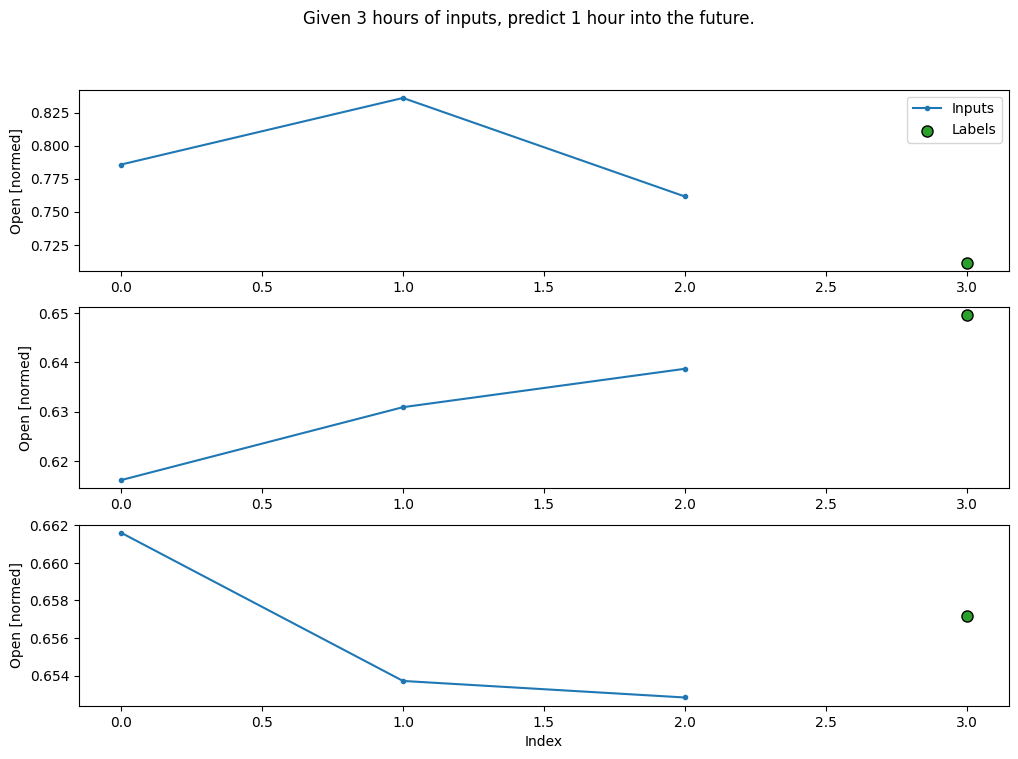

In [254]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [255]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])